# Gradients and GCN Features Fusion Transformer for Point Cloud Segmentation

In [1]:
!gpustat

8d809b5da21a         Wed Aug 31 13:23:00 2022  460.73.01
[0] GeForce RTX 3090 | 59'C,   0 % | 18381 / 24268 MB |
[1] GeForce RTX 3090 | 48'C,   0 % |  5711 / 24268 MB |
[2] GeForce RTX 3090 | 60'C,  70 % | 21272 / 24268 MB |
[3] GeForce RTX 3090 | 47'C,   0 % |  5711 / 24268 MB |
[4] GeForce RTX 3090 | 50'C,   0 % |  5711 / 24268 MB |
[5] GeForce RTX 3090 | 66'C,  95 % | 12771 / 24268 MB |
[6] GeForce RTX 3090 | 48'C,   0 % | 20430 / 24268 MB |
[7] GeForce RTX 3090 | 50'C,   0 % |  5711 / 24268 MB |


In [4]:
available_gpus = [1]
dev = None if len(available_gpus) == 0 else available_gpus[0]

### Imports


In [5]:
import gc
import copy
import os

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset

from dgl.geometry import farthest_point_sampler

from data import ShapeNetPart

In [6]:
def clear_mem(*objs):
    for obj in objs:
        del obj
    gc.collect()
    torch.cuda.empty_cache()

## DGCNN


In [7]:
def knn(x, k):
    inner = -2*torch.matmul(x.transpose(2, 1), x)
    xx = torch.sum(x**2, dim=1, keepdim=True)
    pairwise_distance = -xx - inner - xx.transpose(2, 1)
    # (batch_size, num_points, k)
    idx = pairwise_distance.topk(k=k, dim=-1)[1]
    return idx


def get_graph_feature(x, k, knn_only=False, disp_only=False):
    batch_size = x.size(0)
    num_points = x.size(2)
    x = x.view(batch_size, -1, num_points)
    idx = knn(x, k=k)   # (batch_size, num_points, k)
    device = x.get_device()
    idx_base = torch.arange(0, batch_size).view(-1, 1, 1) * num_points
    if device != -1:
        idx_base = idx_base.cuda(device)
    idx = idx + idx_base
    idx = idx.view(-1)
    _, num_dims, _ = x.size()
    # (batch_size, num_points, num_dims)  -> (batch_size*num_points, num_dims) #   batch_size * num_points * k + range(0, batch_size*num_points)
    x = x.transpose(2, 1).contiguous()
    feature = x.view(batch_size*num_points, -1)[idx, :]
    feature = feature.view(batch_size, num_points, k, num_dims)
    if knn_only:
        return feature
    x = x.view(batch_size, num_points, 1, num_dims).repeat(1, 1, k, 1)
    if disp_only:
        return (feature - x).permute(0, 3, 1, 2)
    feature = torch.cat((feature-x, x), dim=3).permute(0, 3, 1, 2).contiguous()
    return feature      # (batch_size, 2*num_dims, num_points, k)


In [8]:
class Transform_Net(nn.Module):
    def __init__(self, k):
        super(Transform_Net, self).__init__()

        self.k = k

        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm1d(1024)

        self.conv1 = nn.Sequential(nn.Conv2d(6, 64, kernel_size=1, bias=False),
                                   self.bn1,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv2 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=1, bias=False),
                                   self.bn2,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv3 = nn.Sequential(nn.Conv1d(128, 1024, kernel_size=1, bias=False),
                                   self.bn3,
                                   nn.LeakyReLU(negative_slope=0.2))

        self.linear1 = nn.Linear(1024, 512, bias=False)
        self.bn4 = nn.BatchNorm1d(512)
        self.linear2 = nn.Linear(512, 256, bias=False)
        self.bn5 = nn.BatchNorm1d(256)

        self.transform = nn.Linear(256, 3*3)
        nn.init.constant_(self.transform.weight, 0)
        nn.init.eye_(self.transform.bias.view(3, 3))

    def forward(self, x):
        # x (B x 3 x N)
        batch_size = x.size(0)
        # (batch_size, 3, num_points) -> (batch_size, 3*2, num_points, k)
        t = get_graph_feature(x, k=self.k)
        
        t = self.conv1(t)                       # (batch_size, 3*2, num_points, k) -> (batch_size, 64, num_points, k)
        t = self.conv2(t)                       # (batch_size, 64, num_points, k) -> (batch_size, 128, num_points, k)
        t = t.max(dim=-1, keepdim=False)[0]     # (batch_size, 128, num_points, k) -> (batch_size, 128, num_points)
        
        t = self.conv3(t)                       # (batch_size, 128, num_points) -> (batch_size, 1024, num_points)
        t = t.max(dim=-1, keepdim=False)[0]     # (batch_size, 1024, num_points) -> (batch_size, 1024)
        
        t = F.leaky_relu(self.bn4(self.linear1(t)), negative_slope=0.2)     # (batch_size, 1024) -> (batch_size, 512)
        t = F.leaky_relu(self.bn5(self.linear2(t)), negative_slope=0.2)     # (batch_size, 512) -> (batch_size, 256)
        
        t = self.transform(t)                   # (batch_size, 256) -> (batch_size, 3*3)
        t = t.view(batch_size, 3, 3)            # (batch_size, 3*3) -> (batch_size, 3, 3)
        
        # (batch_size, 3, num_points) -> (batch_size, num_points, 3)
        x = x.transpose(2, 1)
        # (batch_size, num_points, 3) * (batch_size, 3, 3) -> (batch_size, num_points, 3)
        x = torch.bmm(x, t)
        # (batch_size, num_points, 3) -> (batch_size, 3, num_points)
        x = x.transpose(2, 1)
        return x

In [9]:
class DGCNN(nn.Module):
    def __init__(self, k, emb_dim):
        super(DGCNN, self).__init__()
        self.k = k
        self.emb_dim = emb_dim
    
        self.conv1 = nn.Sequential(nn.Conv2d(6, 64, kernel_size=1, bias=False),
                                   nn.BatchNorm2d(64),
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1, bias=False),
                                   nn.BatchNorm2d(64),
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv3 = nn.Sequential(nn.Conv2d(64*2, 64, kernel_size=1, bias=False),
                                   nn.BatchNorm2d(64),
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv4 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1, bias=False),
                                   nn.BatchNorm2d(64),
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv5 = nn.Sequential(nn.Conv2d(64*2, 64, kernel_size=1, bias=False),
                                   nn.BatchNorm2d(64),
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv6 = nn.Sequential(nn.Conv1d(192, emb_dim, kernel_size=1, bias=False),
                                   nn.BatchNorm1d(emb_dim),
                                   nn.LeakyReLU(negative_slope=0.2))
        

    def forward(self, x):
        batch_size = x.size(0)
        num_points = x.size(2)

        x = get_graph_feature(x, k=self.k)      # (batch_size, 3, num_points) -> (batch_size, 3*2, num_points, k)
        x = self.conv1(x)                       # (batch_size, 3*2, num_points, k) -> (batch_size, 64, num_points, k)
        x = self.conv2(x)                       # (batch_size, 64, num_points, k) -> (batch_size, 64, num_points, k)
        x1 = x.max(dim=-1, keepdim=False)[0]    # (batch_size, 64, num_points, k) -> (batch_size, 64, num_points)

        x = get_graph_feature(x1, k=self.k)     # (batch_size, 64, num_points) -> (batch_size, 64*2, num_points, k)
        x = self.conv3(x)                       # (batch_size, 64*2, num_points, k) -> (batch_size, 64, num_points, k)
        x = self.conv4(x)                       # (batch_size, 64, num_points, k) -> (batch_size, 64, num_points, k)
        x2 = x.max(dim=-1, keepdim=False)[0]    # (batch_size, 64, num_points, k) -> (batch_size, 64, num_points)

        x = get_graph_feature(x2, k=self.k)     # (batch_size, 64, num_points) -> (batch_size, 64*2, num_points, k)
        x = self.conv5(x)                       # (batch_size, 64*2, num_points, k) -> (batch_size, 64, num_points, k)
        x3 = x.max(dim=-1, keepdim=False)[0]    # (batch_size, 64, num_points, k) -> (batch_size, 64, num_points)

        x = torch.cat((x1, x2, x3), dim=1)      # (batch_size, 64*3, num_points)
        x = self.conv6(x)                       # (batch_size, 64*3, num_points) -> (batch_size, emb_dims, num_points)
        # (batch_size, num_points, emb_dims)
        y = x.view(batch_size, num_points, self.emb_dim)
        
        return y

## Gradients & HOG 3D

### Divide PC into cells of shape N // k

In [ ]:
def get_gradients(x, k, do_pca=False, use_cpu=False):
    '''
    x (Bx3xN) batch of point clouds
    return gradients (BxNx3): direction of maximimal variance at each point
    '''
    x_nn = get_graph_feature(x, k=k, knn_only=True)  # Bx3xN -> BxNxkx3
    if do_pca:
        _, s, v = torch.pca_lowrank(x_nn)  # BxNxkx3 -> BxNx3x3
    else:
        mean = x_nn.mean(dim=2).unsqueeze(dim=2)
        centered = x_nn - mean
        # _, _, v = torch.linalg.svd(centered)  # BxNxkx3 -> BxNx3x3
        _, s, v = np.linalg.svd(
            centered.detach().cpu().numpy(), full_matrices=False)
        v = torch.from_numpy(v)
        s = torch.from_numpy(np.sqrt(s))
        if "LOCAL_RANK" in os.environ:
            v = v.cuda(int(os.environ["LOCAL_RANK"]))
            s = s.cuda(int(os.environ["LOCAL_RANK"]))
        elif not use_cpu:
            v = v.cuda()
            s = s.cuda()
    gradients = v[:, :, 0]  # BxNx3x3 -> BxNx3
    magnitudes = s[:, :, 0].unsqueeze(-1) # BxNx3 -> BxNx1
    return gradients, magnitudes


In [ ]:
def pc_to_fps_knn(x, k, ncells, nn_idx, fps_idx):
    x = x.transpose(1, 2)

    nn_idx = nn_idx.view(-1)
    fps_idx = fps_idx.view(-1)

    batch_size = x.size(0)
    num_dims = x.size(1)
    num_pts = x.size(2)

    x_nn = x.contiguous().view(batch_size * num_pts, -1)[nn_idx, :]
    x_fps = x_nn.view(batch_size * num_pts, k, num_dims)[fps_idx, :]

    x_fps = x_fps.view(batch_size, ncells, k, num_dims)
    return x_fps


In [ ]:
def compute_hog(pointcloud, k):
    '''
    Compute Histogram of Oriented Gradients for a point cloud
    given gradients at every point

    pointcloud (Bx3xN tensor)
    '''

    batch_size = pointcloud.size(0)
    num_pts = pointcloud.size(2)

    nn_idx = knn(pointcloud, k=k).view(-1)
    npoints = num_pts // k
    fps_idx = farthest_point_sampler(pointcloud.transpose(1, 2), npoints)
    # B x N x k x 3
    x_nn = pointcloud.view(batch_size * num_pts, -1)[nn_idx, :].view(batch_size, num_pts, k, 3)
    
    mean = x_nn.mean(dim=2).unsqueeze(dim=2)
    centered = x_nn - mean
    _, s, v = np.linalg.svd(
        centered.detach().cpu().numpy(), full_matrices=False)
    v = torch.from_numpy(v)
    s = torch.from_numpy(np.sqrt(s))
    gradients = v[:, :, 0]  # BxNx3x3 -> BxNx3
    magnitudes = s[:, :, 0].unsqueeze(-1)  # BxNx3 -> BxNx1

   
    gradient_cells = pc_to_fps_knn(gradients, k, npoints, nn_idx, fps_idx)
    zenith = torch.acos(gradient_cells[:, :, :, 2]).unsqueeze(-1) * 180 / np.pi
    azimuth = torch.atan(
        gradient_cells[:, :, :, 1] / gradient_cells[:, :, :, 0]).unsqueeze(-1) * 180 / np.pi
    del gradient_cells
    magnitude_cells = pc_to_fps_knn(magnitudes, k, npoints, nn_idx, fps_idx)
    # x y z magnitude
    cells = torch.cat((zenith.int(), azimuth.int(), magnitude_cells), dim=3)
    cells[cells < 0] += 180

    histogram = torch.zeros((batch_size, npoints, 9, 2))

    bins = torch.floor(cells[:, :, :, :2] / 20 - 0.5) % 9
    first_centers = 20 * (bins + 1.5)
    first_votes = cells[:, :, :,
                        2].unsqueeze(-1) * (first_centers - cells[:, :, :, :2]) / 20
    second_centers = 20 * (bins + 0.5)
    second_votes = cells[:, :, :,
                         2].unsqueeze(-1) * (cells[:, :, :, :2] - second_centers) / 20

    for c in range(9):
        histogram[:, :, c, :] = (
            first_votes * (bins == c)).sum(dim=2) + (second_votes * (bins == ((c+1) % 9))).sum(dim=2)
    norm_hog = F.normalize(histogram, p=2.0, dim=1)
    squeezed = norm_hog.view(batch_size, -1, 2)
    return squeezed


### Every point is a histogram of its nearest neighbors (1x1 cells)

In [10]:
def compute_hog_1x1(x, k, use_cpu=False):
    '''
    Compute histogram of oriented gradients using cell size of 1
    so that every point gets information of its neighbors

    x (B x 3 x N)
    k (number of nbrs to consider)
    '''
    batch_size = x.size(0)
    num_pts = x.size(2)

    nn_idx = knn(x, k).view(-1)
    # B x N x k x 3
    x_nn = x.contiguous().view(batch_size * num_pts, -
                  1)[nn_idx, :].view(batch_size, num_pts, k, 3)
    # center the pointcloud
    mean = x_nn.mean(dim=2).unsqueeze(dim=2)
    centered = x_nn - mean
    # perform svd to obtain gradients & magnitudes
    # considering s as mag because |v|=1
    _, s, v = np.linalg.svd(centered.detach().cpu().numpy(), full_matrices=False)
    # convert to tensors
    v = torch.from_numpy(v)
    s = torch.from_numpy(np.sqrt(s))
    # move to appropriate device
    if "LOCAL_RANK" in os.environ:
            v = v.cuda(int(os.environ["LOCAL_RANK"]))
            s = s.cuda(int(os.environ["LOCAL_RANK"]))
    elif not use_cpu:
        v = v.cuda()
        s = s.cuda()
    # get the first element (largest variance)
    gradients = v[:, :, 0]  # BxNx3x3 -> BxNx3
    magnitudes = s[:, :, 0].unsqueeze(-1)  # BxNx3 -> BxNx1

    # orient grads and mags into knn shape
    gradients_nn = gradients.contiguous().view(
        batch_size * num_pts, -1)[nn_idx, :].view(batch_size, num_pts, k, 3)
    magnitudes_nn = magnitudes.contiguous().view(
        batch_size * num_pts, -1)[nn_idx, :].view(batch_size, num_pts, k, 1)
    # compute angles
    zenith = torch.acos(gradients_nn[:, :, :, 2]).unsqueeze(-1) * 180 / np.pi
    azimuth = torch.atan(
        gradients_nn[:, :, :, 1] / gradients_nn[:, :, :, 0]).unsqueeze(-1) * 180 / np.pi
    # stack into cells (zenith, azimuth, magnitude)
    cells = torch.cat((zenith.int(), azimuth.int(), magnitudes_nn), dim=-1)
    # don't differentiate between signed and unsigned
    cells[cells < 0] += 180
    # init histogram
    if use_cpu:
        histogram = torch.zeros((batch_size, num_pts, 9, 2))
    else:
        if 'LOCAL_RANK' in os.environ:
            histogram = torch.zeros((batch_size, num_pts, 9, 2), device=torch.device(
                int(os.environ['LOCAL_RANK'])))
        else:
            histogram = torch.zeros(
                (batch_size, num_pts, 9, 2), device=torch.device('cuda'))
    # 20 degrees bins computed from angles
    bins = torch.floor(cells[:, :, :, :2] / 20.0 - 0.5) % 9
    first_centers = 20 * ((bins + 1) % 9 + 0.5)
    first_votes = cells[:, :, :, 2].unsqueeze(-1) * \
        ((first_centers - cells[:, :, :, :2]) % 180) / 20
    second_centers = 20 * (bins + 0.5)
    second_votes = cells[:, :, :, 2].unsqueeze(-1) * \
        ((cells[:, :, :, :2] - second_centers) % 180) / 20
    for c in range(9):
        histogram[:, :, c] += (first_votes * (bins == c)).sum(dim=2)
        histogram[:, :, (c+1) % 9] += (second_votes * (bins == c)).sum(dim=2)
    histogram = F.normalize(histogram, p=2.0, dim=2)
    histogram = histogram.view(batch_size, num_pts, -1)
    return histogram


In [11]:
ds = ShapeNetPart(2048, partition="trainval")

In [61]:
def plot_hist(i):
    pc = ds[i][0]
    t = torch.from_numpy(pc).unsqueeze(0).transpose(1, 2)
    hog = compute_hog_1x1(t, k=32, use_cpu=True).squeeze()
    zenith = hog[:, :9]
    azimuth = hog[:, 9:]

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    freq = zenith.sum(dim=0).numpy()
    freq /= freq.sum()
    freq *= 100
    bins = np.linspace(0, 160, 9)
    plt.title("zenith")
    plt.bar(bins, freq, width=10)

    plt.subplot(1, 2, 2)
    freq = azimuth.sum(dim=0).numpy()
    freq /= freq.sum()
    freq *= 100
    bins = np.linspace(0, 160, 9)
    plt.bar(bins, freq, width=10)
    plt.title("azimuth")

    plt.show()


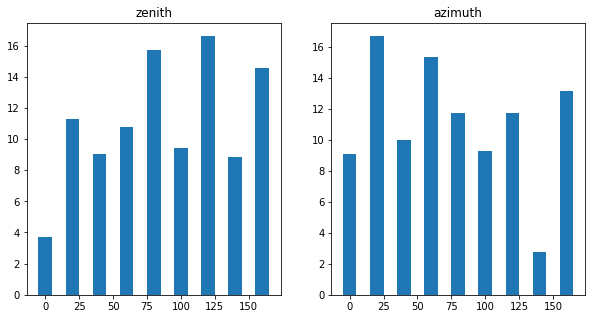

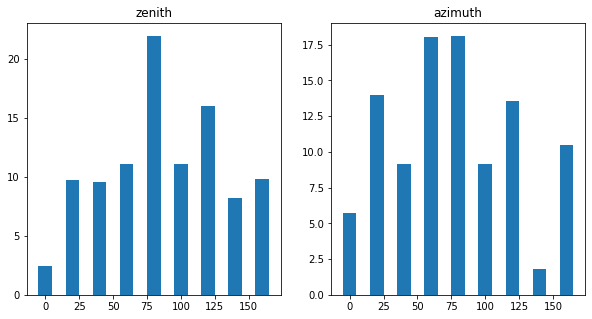

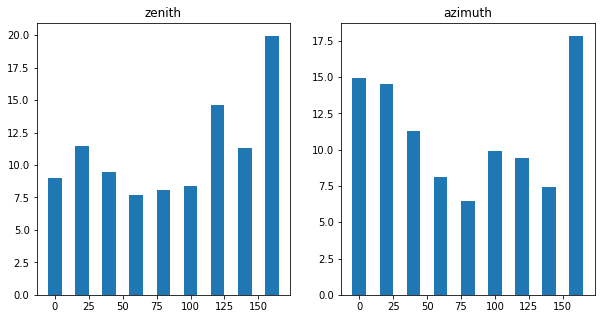

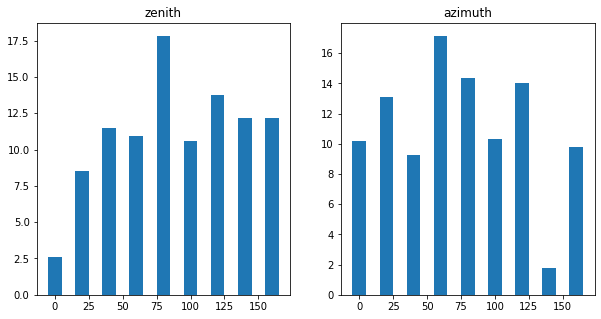

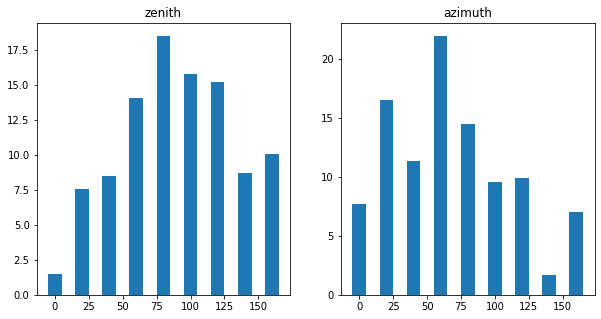

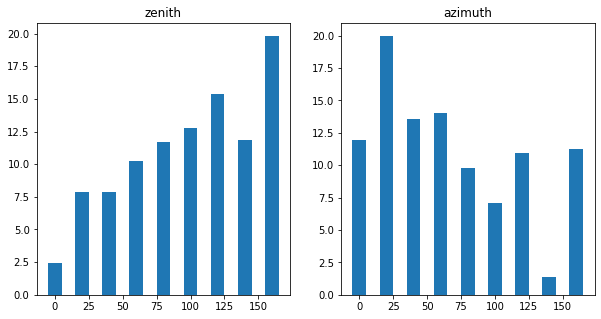

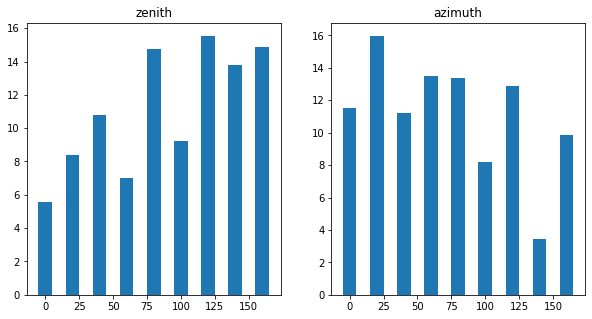

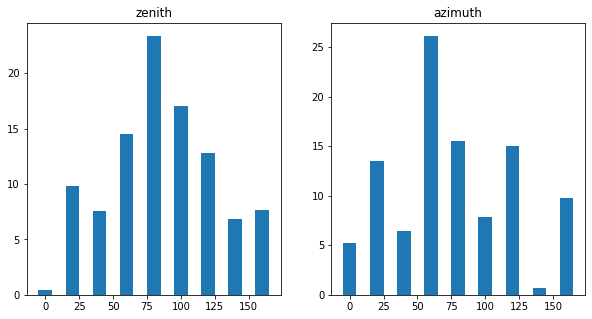

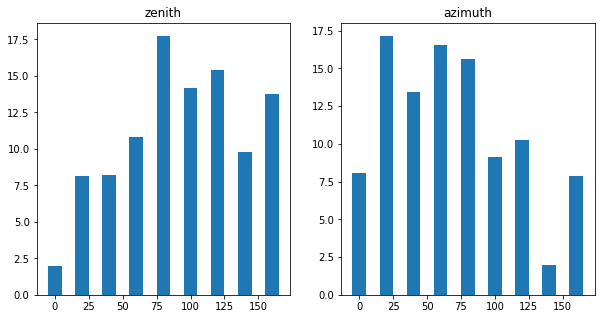

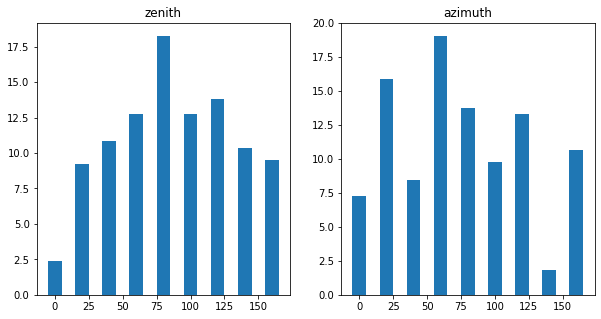

In [63]:
for i in range(10):
    plot_hist(i)


## Encoder

**Point Transformer**

1. Decrease `emb_dims` by 1x1 conv like DETR
2. Use attention mech of Point Transformer (Hengshuang)
3. Resize to original dim
3. Design encoder of original transformer (without multihead for now)

**PointBERT**

- Patch based embeddings... (1 embedding for 1 patch)


### Point Transformer by [qq456cvb](https://github.com/qq456cvb/Point-Transformers/blob/master/models/Hengshuang/transformer.py)

In [ ]:
def square_distance(src, dst):
    return torch.sum((src[:, :, None] - dst[:, None]) ** 2, dim=-1)


def index_points(points, idx):
    raw_size = idx.size()
    idx = idx.reshape(raw_size[0], -1)
    res = torch.gather(
        points, 1, idx[..., None].expand(-1, -1, points.size(-1)))
    return res.reshape(*raw_size, -1)

In [ ]:
class PointTransformerLayer(nn.Module):
    def __init__(self, d_points=256, d_model=64, k=16) -> None:
        super(PointTransformerLayer, self).__init__()

        self.k = k

        self.fc1 = nn.Linear(d_points, d_model)
        self.fc2 = nn.Linear(d_model, d_points)

        self.fc_delta = nn.Sequential(
            nn.Linear(3, d_model, bias=True),
            nn.ReLU(),
            nn.Linear(d_model, d_model)
        )
        self.fc_gamma = nn.Sequential(
            nn.Linear(d_model, d_model, bias=True),
            nn.ReLU(),
            nn.Linear(d_model, d_model)
        )
        self.w_qs = nn.Linear(d_model, d_model, bias=False)
        self.w_ks = nn.Linear(d_model, d_model, bias=False)
        self.w_vs = nn.Linear(d_model, d_model, bias=False)
        
        
    def forward(self, xyz, features):
        # xyz: b x n x 3, features: b x n x f
        dists = square_distance(xyz, xyz)
        knn_idx = dists.argsort()[:, :, :self.k]  # b x n x k
        knn_xyz = index_points(xyz, knn_idx)
        
        pre = features
        x = self.fc1(features)
        q, k, v = self.w_qs(x), index_points(self.w_ks(x), knn_idx), index_points(self.w_vs(x), knn_idx)

        pos_enc = self.fc_delta(xyz[:, :, None] - knn_xyz)  # b x n x k x f
        
        attn = self.fc_gamma(q[:, :, None] - k + pos_enc)
        attn = F.softmax(attn, dim=-2)  # b x n x k x f
        attn = F.normalize(attn, p=1.0, dim=-2)
        
        res = torch.einsum('bmnf,bmnf->bmf', attn, v + pos_enc)
        res = self.fc2(res) + pre
        return res

### Encoder Layer

In [ ]:
def _get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module)] * N)

In [ ]:
# https://github.com/POSTECH-CVLab/point-transformer/blob/master/model/pointtransformer/pointtransformer_seg.py

class EncoderLayer(nn.Module):

    def __init__(self,
                 in_channels,
                 mid_channels=256,
                 out_channels=None,
                 ):
        super(EncoderLayer, self).__init__()
        # output has same dim has input
        out_channels = in_channels if out_channels is None else out_channels
        # only use for large dim inputs
        mid_channels = mid_channels if in_channels > mid_channels else in_channels

        self.scale_dim = nn.Sequential(
            nn.Conv1d(in_channels, mid_channels, 1, bias=False),
            nn.BatchNorm1d(mid_channels),
            nn.ReLU(inplace=False)
        )

        self.attention = PointTransformerLayer(d_points=mid_channels)
        self.bn = nn.BatchNorm1d(mid_channels)

        self.restore_dim = nn.Sequential(
            nn.Conv1d(mid_channels, out_channels, 1, bias=False),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=False)
        )

        self.skip_conn = nn.Sequential(
            nn.LayerNorm(out_channels),
            nn.ReLU()
        )
            

    def forward(self, p, x):
        # x (B x N x C)
        # p (B x N x 3)

        bs = x.size(0)
        n = x.size(1)

        # x -> B x C x N -> B x mid_channels x N
        y = self.scale_dim(x.transpose(1, 2))
        # p (B x N x 3) & y (B x mid_channels x N) -> (B x mid_channels x N )
        y = F.relu(self.bn(self.attention(
            p, y.transpose(1, 2)).transpose(1, 2)))
        # (B x N x mid_channels) -> (B x out_channels x N) -> (B x N x out_channels)

        y = self.restore_dim(y)
        y = y.transpose(1, 2)
        # skip connection (won't work if in_channels != out_channels)
        y = y + x
        y = self.skip_conn(y)
        return y

In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self, in_channels, num_layers, **kwargs):
        super(TransformerEncoder, self).__init__()
        
        self.layers = _get_clones(EncoderLayer(in_channels=in_channels, **kwargs), num_layers)
        self.norm = nn.LayerNorm(in_channels)

    def forward(self, pc, x):
        for layer in self.layers:
            x = layer(pc, x)
        y = self.norm(x)
        return y

## Fusion

In [ ]:
class MultiHeadAttention(nn.Module):
    '''
    Self attention with multiple heads
    '''

    def __init__(self, d_graph, d_grads, d_k, num_heads, d_v=None,dropout=.1):
        '''
        :param d_model: Output dimensionality of the model
        :param d_k: Dimensionality of queries and keys
        :param d_v: Dimensionality of values
        :param h: Number of heads
        '''
        super(MultiHeadAttention, self).__init__()

        self.d_graph = d_graph
        self.d_grads = d_grads
        self.d_k = d_k
        self.d_v = d_k if d_v is None else d_v
        self.h = num_heads

        self.fc_q = nn.Linear(self.d_grads, self.h * self.d_k)
        self.fc_k = nn.Linear(self.d_graph, self.h * self.d_k)
        self.fc_v = nn.Linear(self.d_graph, self.h * self.d_v)
        self.fc_o = nn.Linear(self.h * self.d_v, self.d_graph)
        self.dropout = nn.Dropout(dropout)

        self.init_weights()


    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, queries, keys, values, attention_mask=None, attention_weights=None):
        '''
        Computes
        :param queries: Queries (b_s, nq, d_grads)
        :param keys: Keys (b_s, nk, d_graph)
        :param values: Values (b_s, nk, d_graph)
        :param attention_mask: Mask over attention values (b_s, h, nq, nk). True indicates masking.
        :param attention_weights: Multiplicative weights for attention values (b_s, h, nq, nk).
        :return:
        '''
        b_s, nq = queries.shape[:2]
        nk = keys.shape[1]

        q = self.fc_q(queries).view(b_s, nq, self.h, self.d_k).permute(0, 2, 1, 3)  # (b_s, h, nq, d_k)
        k = self.fc_k(keys).view(b_s, nk, self.h, self.d_k).permute(0, 2, 3, 1)  # (b_s, h, d_k, nk)
        v = self.fc_v(values).view(b_s, nk, self.h, self.d_v).permute(0, 2, 1, 3)  # (b_s, h, nk, d_v)

        att = torch.matmul(q, k) / np.sqrt(self.d_k)  # (b_s, h, nq, nk)
        if attention_weights is not None:
            att = att * attention_weights
        if attention_mask is not None:
            att = att.masked_fill(attention_mask, -np.inf)

        att = F.softmax(att, dim=-1)
        att = F.normalize(att, p=1.0, dim=-1)
        att = self.dropout(att)

        out = torch.matmul(att, v).permute(0, 2, 1, 3).contiguous().view(b_s, nq, self.h * self.d_v)  # (b_s, nq, h*d_v)
        out = self.fc_o(out)  # (b_s, nq, d_graph)
        return out

In [ ]:
class Offset_Attention(nn.Module):

    def __init__(self, in_channels_graph, in_channels_grads, 
                 mid_channels=64, out_channels=None, 
                 num_heads=8, dropout=0.1):
        super(Offset_Attention, self).__init__()

        if out_channels is None:
            out_channels = in_channels_graph

        self.attention = MultiHeadAttention(num_heads=num_heads, d_graph=in_channels_graph,
                                            d_grads=in_channels_grads, d_k=mid_channels, 
                                            dropout=dropout)
        
        self.lbr = nn.Sequential(
            nn.Conv1d(out_channels, out_channels, 1, bias=False),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=False)
            )

    def forward(self, grads, graph):
        # grads (B x N x 3)
        # graph (B x N x F)
        attn_output = self.attention(queries=grads, keys=graph, values=graph)
        attn_output = attn_output - graph
        y = self.lbr(attn_output.transpose(1, 2)).transpose(1, 2)
        return y

## Decoder

- Pointformer LGT block "*adopts a multi-scale cross-attention module to build connections between local features ... and global features*"

In [ ]:
class Decoder(nn.Module):
    def __init__(self, d_model, nheads, nlayers, n_classes) -> None:
        super(Decoder, self).__init__()

        layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nheads,
                                           batch_first=True)
        self.decoder = nn.TransformerDecoder(layer, num_layers=nlayers)
        

    def forward(self, tgt, memory):
        # tgt (B x N x F) memory (B x N x F)
        tgt = self.decoder(tgt, memory)  # (B x N x F)
        return tgt

## Classification Layer

In [ ]:
class Classifier(nn.Module):
    def __init__(self, d_model, n_classes):
        super(Classifier, self).__init__()

        self.clf = nn.Sequential(
            nn.Conv1d(d_model, d_model // 8, 1, bias=False),
            nn.BatchNorm1d(d_model // 8),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv1d(d_model // 8, d_model // 64, 1, bias=False),
            nn.BatchNorm1d(d_model // 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv1d(d_model // 64, n_classes, 1, bias=False)
        )

    def forward(self, x):
        # x (B x N x F)
        return self.clf(x.transpose(1, 2))  # (B x n_classes x N)


## Test Arch

In [ ]:
class Net(nn.Module):
    def __init__(self, k, emb_dim, nlayers, nclasses):
        super(Net, self).__init__()
        # number of nearest neighbors
        self.k = k
        # transform to canonical representation
        self.tnet = Transform_Net(k=k)
        self.tnet.load_state_dict(torch.load("ckpts/tnet.pt"))
        # get graph features
        self.dgcnn = DGCNN(k=k, emb_dim=emb_dim)
        self.dgcnn.load_state_dict(torch.load("ckpts/dgcnn.pt"))
        # produce attn_map from graph features
        self.graph_encoder = TransformerEncoder(
            in_channels=emb_dim, num_layers=nlayers)
        # produce attn_map from gradients
        self.gradients_encoder = TransformerEncoder(
            in_channels=3, num_layers=nlayers)
        # fuse gradients and graph attention
        self.fusion_net = Offset_Attention(in_channels_graph=emb_dim, in_channels_grads=3)
        # get segmap
        # self.decoder = Decoder(d_model=emb_dim, nheads=4,
        #                        nlayers=nlayers, n_classes=50)
        self.clf = Classifier(d_model=emb_dim, n_classes=nclasses)

    def forward(self, x):
        # x = B x 3 x N
        pcd = self.tnet(x) # B x 3 x N
        # B x 3 x N -> B x N x emb_dim
        graph_ftrs = self.dgcnn(pcd)
        # B x N x 3
        gradient_ftrs = get_gradients(x, k=self.k)
        # B x 3 x N -> B x N x 3
        pcd = pcd.transpose(1, 2)
        # (B x N x 3) & (B x N x emb_dim) -> B x N x emb_dim
        graph_attn_map = self.graph_encoder(pcd, graph_ftrs)
        # (B x N x 3) & (B x N x 3) -> B x N x 3
        gradients_attn_map = self.gradients_encoder(pcd, gradient_ftrs)
        # (B x N x 3) & (B x N x emb_dim) -> B x N x emb_dim
        fused_attn_map = self.fusion_net(gradients_attn_map, graph_attn_map)
        # (B x N x emb_dim) & (B x N x emb_dim) -> B x n_classes x N
        # segmap = self.decoder(graph_ftrs, fused_attn_map)
        scores = self.clf(fused_attn_map)
        return scores


In [ ]:
bs = 4
emb_dim = 1024
k = 16
dev = 4

In [ ]:
model = Net(k=k, emb_dim=emb_dim, nlayers=4, nclasses=50).cuda(dev)

In [ ]:
sum(p.numel() for p in model.parameters())

In [ ]:
!gpustat

In [ ]:
# x = torch.randn((2, 2048, 3), device=torch.device(dev)).transpose(1, 2)
# y = model(x)
# y.shape

## Ignite Testing

In [ ]:
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import ConfusionMatrix, IoU, Loss, mIoU
from ignite.handlers import ModelCheckpoint, global_step_from_engine
from ignite.contrib.handlers import TensorboardLogger


In [ ]:
device = torch.device(dev)

In [ ]:
dataset = ShapeNetPart(2048, 'train', task='seg')
N = len(dataset)

train_ds = Subset(dataset, list(range(2)))
val_ds = Subset(dataset, [i for i in range(N-2, N)])

In [ ]:
train_loader = DataLoader(train_ds, batch_size=2)
val_loader = DataLoader(val_ds, batch_size=2)


In [ ]:
model = Net(k=16, emb_dim=1024, ).to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=5e-3)
criterion = nn.CrossEntropyLoss()

In [ ]:
miou = JaccardIndex(50).cuda(dev)

In [ ]:
for epoch in range(100):
    optimizer.zero_grad()
    total_loss, total_iou = 0, 0
    for b, (x, y) in enumerate(train_loader):
        x, y = x.cuda(dev), y.cuda(dev)
        y_out = model(x)
        loss = criterion(y_out, y)
        total_loss += loss
        preds = torch.argmax(y_out, dim=1)
        total_iou += miou(preds, y)
        loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"{epoch} Loss:", (total_loss / 4).item(),
              " mIOU:", (total_iou / 4).item())


In [ ]:
trainer = create_supervised_trainer(model, optimizer, criterion, device)

cm_metric = ConfusionMatrix(num_classes=50)
val_metrics = {"IoU": mIoU(cm_metric), "loss": Loss(criterion)}

train_evaluator = create_supervised_evaluator(
    model, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(
    model, metrics=val_metrics, device=device)


In [ ]:
# How many batches to wait before logging training status
log_interval = 2


@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    print(
        f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    print(
        f"Training Results - Epoch[{trainer.state.epoch}] Avg IoU: {metrics['IoU']:.2f} Avg loss: {metrics['loss']:.2f}")


@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    print(
        f"Validation Results - Epoch[{trainer.state.epoch}] Avg IoU: {metrics['IoU']:.2f} Avg loss: {metrics['loss']:.2f}")


In [ ]:
# Score function to return current value of any metric we defined above in val_metrics
def score_function(engine):
    return engine.state.metrics["IoU"]


# Checkpoint to store n_saved best models wrt score function
model_checkpoint = ModelCheckpoint(
    "checkpoint",
    n_saved=2,
    filename_prefix="best",
    score_function=score_function,
    score_name="IoU",
    require_empty=False,
    global_step_transform=global_step_from_engine(
        trainer),  # helps fetch the trainer's state
)

# Save the model after every epoch of val_evaluator is completed
val_evaluator.add_event_handler(
    Events.COMPLETED, model_checkpoint, {"model": model})


In [ ]:
# Define a Tensorboard logger
tb_logger = TensorboardLogger(log_dir="tb-logger")

# Attach handler to plot trainer's loss every 100 iterations
tb_logger.attach_output_handler(
    trainer,
    event_name=Events.ITERATION_COMPLETED(every=100),
    tag="training",
    output_transform=lambda loss: {"batch_loss": loss},
)

# Attach handler for plotting both evaluators' metrics after every epoch completes
for tag, evaluator in [("training", train_evaluator), ("validation", val_evaluator)]:
    tb_logger.attach_output_handler(
        evaluator,
        event_name=Events.EPOCH_COMPLETED,
        tag=tag,
        metric_names="all",
        global_step_transform=global_step_from_engine(trainer),
    )


In [ ]:
trainer.run(train_loader, max_epochs=10)

In [ ]:
# Let's close the logger and inspect our results
tb_logger.close()

%load_ext tensorboard

%tensorboard - -logdir = .


In [ ]:
# At last we can view our best models
!ls checkpoints
